In [1]:
import ipyparallel as ipp

cluster = ipp.Cluster(engines="mpi", n=6).start_and_connect_sync()
%autopx

Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

%autopx enabled


In [2]:
from mpi4py import MPI

mpi_comm = MPI.COMM_WORLD
rank = mpi_comm.Get_rank()

In [3]:
%%capture
from pace.util import CubedSphereCommunicator, CubedSpherePartitioner, TilePartitioner

layout = (1, 1)
partitioner = CubedSpherePartitioner(TilePartitioner(layout))
communicator = CubedSphereCommunicator(mpi_comm, partitioner)

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

In [4]:
from pace.util import QuantityFactory, SubtileGridSizer

backend = "numpy"

sizer = SubtileGridSizer.from_tile_params(
    nx_tile=128,
    ny_tile=128,
    nz=79,
    n_halo=3,
    extra_dim_lengths={},
    layout=layout,
    tile_partitioner=partitioner.tile,
    tile_rank=communicator.tile.rank,
)

quantity_factory = QuantityFactory.from_backend(sizer=sizer, backend=backend)

In [5]:
from datetime import datetime

restart_path = "/home/ajdas/pace/restart_data/v5.0"
restart_time = datetime.strptime("2020-08-26 12:00:01", "%Y-%m-%d %H:%M:%S")
fortran_data = True

#serial_path = "/home/ajdas/pace/test_data/8.1.1/c12_6ranks_baroclinic_dycore_microphysics/driver/"
#serialized_grid = True

In [6]:
%%capture
from pace.driver.initialization import RestartConfig

restart_config = RestartConfig(path=restart_path, start_time=restart_time, fortran_data=fortran_data)
fortran_state = restart_config.get_driver_state(quantity_factory, communicator)

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

In [7]:
import numpy as np
from pace.util import Quantity

lon_driver = Quantity(
    data = fortran_state.grid_data.lon.data * 180/np.pi,
    dims = ("x_interface", "y_interface"),
    units = "degree",
    origin = (3, 3),
    extent = (129, 129),
    gt4py_backend=backend,
)

lat_driver = Quantity(
    data = fortran_state.grid_data.lat.data * 180/np.pi,
    dims = ("x_interface", "y_interface"),
    units = "degree",
    origin = (3, 3),
    extent = (129, 129),
    gt4py_backend=backend,
)

lona_driver = Quantity(
    data = fortran_state.grid_data.lon_agrid.data * 180/np.pi,
    dims = ("x", "y"),
    units = "degree",
    origin = (3, 3),
    extent = (128, 128),
    gt4py_backend=backend,
)

lata_driver = Quantity(
    data = fortran_state.grid_data.lat_agrid.data * 180/np.pi,
    dims = ("x", "y"),
    units = "degree",
    origin = (3, 3),
    extent = (128, 128),
    gt4py_backend=backend,
)

area_driver = Quantity(
    data = fortran_state.grid_data.area.data,
    dims = ("x", "y"),
    units = "degree",
    origin = (3, 3),
    extent = (128, 128),
    gt4py_backend=backend,
)

lon_driver_global = communicator.gather(lon_driver)
lat_driver_global = communicator.gather(lat_driver)
lona_driver_global = communicator.gather(lona_driver)
lata_driver_global = communicator.gather(lata_driver)
area_driver_global = communicator.gather(area_driver)

In [8]:
from netCDF4 import Dataset
import numpy as np

datadir = "/home/ajdas/pace/restart_data/v5.0/"

data = Dataset(datadir + "grid_spec.tile%s.nc" % (rank+1), "r")
lon_edges = np.array(data["grid_lon"])
lat_edges = np.array(data["grid_lat"])
lon_centers = np.array(data["grid_lont"])
lat_centers = np.array(data["grid_latt"])
area = np.array(data["area"])
#data.close()

zero_array = np.zeros(lat_driver.data.shape)

In [9]:
lon_fortran = Quantity(
    data = zero_array,
    dims = ("x_interface", "y_interface"),
    units = "degree",
    origin = (3, 3),
    extent = (129, 129),
    gt4py_backend=backend,
)
lon_fortran.data[3:-3, 3:-3] = lon_edges

lat_fortran = Quantity(
    data = zero_array,
    dims = ("x_interface", "y_interface"),
    units = "degree",
    origin = (3, 3),
    extent = (129, 129),
    gt4py_backend=backend,
)
lat_fortran.data[3:-3, 3:-3] = lat_edges

lona_fortran = Quantity(
    data = zero_array,
    dims = ("x", "y"),
    units = "degree",
    origin = (3, 3),
    extent = (128, 128),
    gt4py_backend=backend,
)
lona_fortran.data[3:-4, 3:-4] = lon_centers

lata_fortran= Quantity(
    data = zero_array,
    dims = ("x", "y"),
    units = "degree",
    origin = (3, 3),
    extent = (128, 128),
    gt4py_backend=backend,
)
lata_fortran.data[3:-4, 3:-4] = lat_centers

area_fortran = Quantity(
    data = zero_array,
    dims = ("x", "y"),
    units = "degree",
    origin = (3, 3),
    extent = (128, 128),
    gt4py_backend=backend,
)
area_fortran.data[3:-4, 3:-4] = area

lon_fortran_global = communicator.gather(lon_fortran)
lat_fortran_global = communicator.gather(lat_fortran)
lona_fortran_global = communicator.gather(lona_fortran)
lata_fortran_global = communicator.gather(lata_fortran)
area_fortran_global = communicator.gather(area_fortran)

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

[output:0]

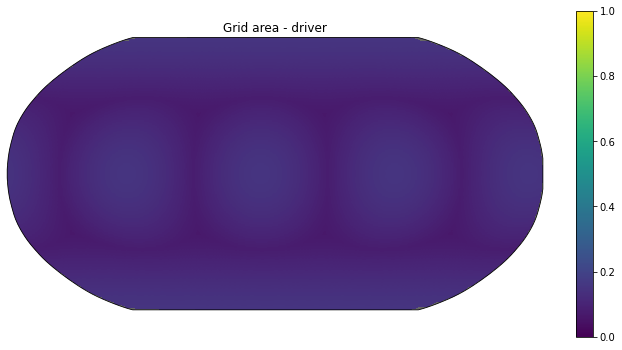

[output:0]

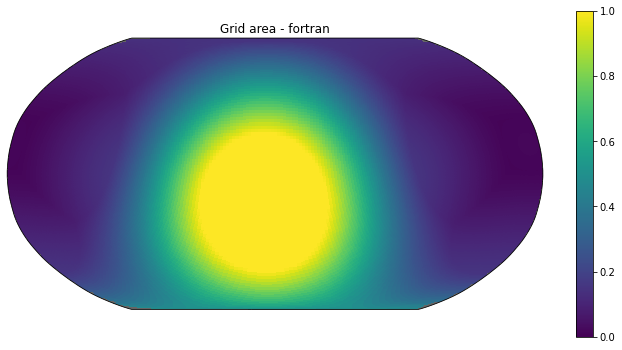

In [10]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from fv3viz import pcolormesh_cube

if rank == 0:
    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor("white")
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    ax.set_facecolor(".4")

    # plot computational mesh
    f1 = pcolormesh_cube(
        lat_driver_global.data,
        lon_driver_global.data,
        area_driver_global.data * 2e-11,
        cmap="viridis",
        vmin=0,
        vmax=1,
    )
    plt.colorbar(f1, )

    ax.set_title("Grid area - driver")


    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor("white")
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    ax.set_facecolor(".4")

    # plot computational mesh
    f1 = pcolormesh_cube(
        lat_fortran_global.data,
        lon_fortran_global.data,
        area_fortran_global.data * 2e-11,
        cmap="viridis",
        vmin=0,
        vmax=1,
    )

    plt.colorbar(f1, )

    ax.set_title("Grid area - fortran")

    plt.show()

In [40]:
from pace.util.grid import MetricTerms
metric_terms = MetricTerms(
        quantity_factory=quantity_factory, communicator=communicator
    )

In [41]:
metric_terms_grid = metric_terms._grid.data
metric_terms_grid_0 = metric_terms_grid[:, :, 0] * 180 / np.pi # longitude
metric_terms_grid_1 = metric_terms_grid[:, :, 1] * 180 / np.pi # latitude

In [42]:
metric_terms_grid_try = np.empty(metric_terms_grid.shape)
metric_terms_grid_try[3:-3, 3:-3, 0] = np.deg2rad(lon_edges)
metric_terms_grid_try[3:-3, 3:-3, 1] = np.deg2rad(lat_edges)

In [43]:
# lon_edges

In [44]:
print("pre:", metric_terms.agrid.data[3:-3, 3:-3, 0].min(), metric_terms.agrid.data[3:-3, 3:-3, 0].max())
metric_terms.grid.data[:] = metric_terms_grid_try
metric_terms._init_agrid()
print("post:", metric_terms.agrid.data[3:-3, 3:-3, 0].min(), metric_terms.agrid.data[3:-3, 3:-3, 0].max())
print("compare:", np.deg2rad(lon_centers).min(), np.deg2rad(lon_centers).max())


[stdout:5] pre: 0.0010847101566659413 6.283030161109942
post: 1.7466452202284555 4.274889094066131
compare: 2.7216034 3.2997825


[stdout:1] pre: 0.6108652381980152 2.186779059066111
post: 0.07482114528336377 6.22160889961827
compare: 3.252269 4.417842


[stdout:3] pre: 2.181661564992912 3.7575753858610073
post: 1.603543942433687 3.835381511044071
compare: 2.1860044 3.8353815


[stdout:4] pre: 3.752457891787808 5.328371712655904
post: 1.603543942433687 3.289311135431442
compare: 1.6035439 2.7691169


[stdout:2] pre: 0.001084710156667325 6.283030161109942
post: 0.0005213855471128401 6.281799093913148
compare: 0.0005213555 6.281799


[stdout:0] pre: 0.008049315696714496 6.279553623659469
post: 0.027538582849462718 6.271748755683029
compare: 0.027538741 6.271749


In [45]:
import numpy as np
from pace.util import Quantity

lon_mt = Quantity(
    data = metric_terms.lon.data * 180/np.pi,
    dims = ("x_interface", "y_interface"),
    units = "degree",
    origin = (3, 3),
    extent = (129, 129),
    gt4py_backend=backend,
)

lat_mt = Quantity(
    data = metric_terms.lat.data * 180/np.pi,
    dims = ("x_interface", "y_interface"),
    units = "degree",
    origin = (3, 3),
    extent = (129, 129),
    gt4py_backend=backend,
)

lona_mt = Quantity(
    data = metric_terms.lon_agrid.data * 180/np.pi,
    dims = ("x", "y"),
    units = "degree",
    origin = (3, 3),
    extent = (128, 128),
    gt4py_backend=backend,
)

lata_mt= Quantity(
    data = metric_terms.lat_agrid.data * 180/np.pi,
    dims = ("x", "y"),
    units = "degree",
    origin = (3, 3),
    extent = (128, 128),
    gt4py_backend=backend,
)

area_mt = Quantity(
    data = metric_terms.area.data,
    dims = ("x", "y"),
    units = "degree",
    origin = (3, 3),
    extent = (128, 128),
    gt4py_backend=backend,
)

lon_mt_global = communicator.gather(lon_mt)
lat_mt_global = communicator.gather(lat_mt)
lona_mt_global = communicator.gather(lona_mt)
lata_mt_global = communicator.gather(lata_mt)
area_mt_global = communicator.gather(area_mt)

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

[output:0]

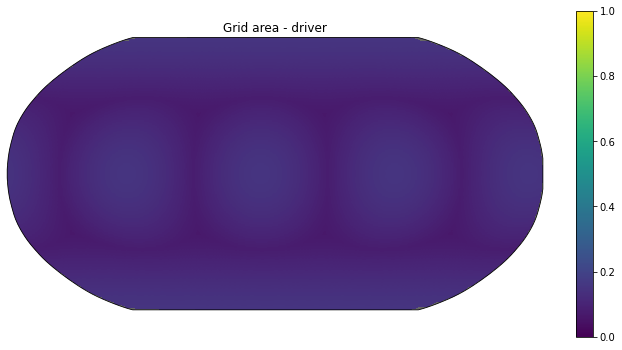

[output:0]

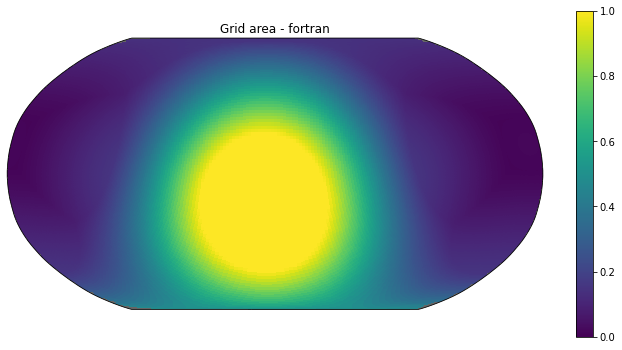

[output:0]

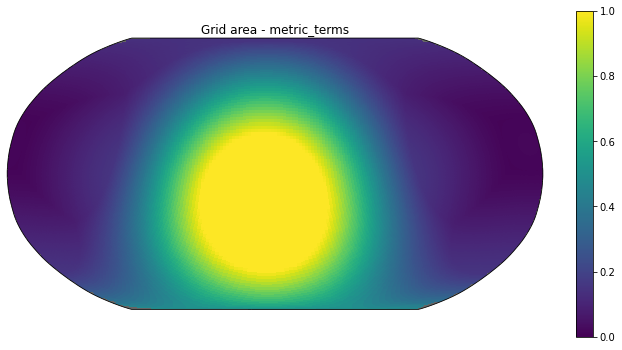

In [46]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from fv3viz import pcolormesh_cube

if rank == 0:
    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor("white")
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    ax.set_facecolor(".4")

    # plot computational mesh
    f1 = pcolormesh_cube(
        lat_driver_global.data,
        lon_driver_global.data,
        area_driver_global.data * 2e-11,
        cmap="viridis",
        vmin=0,
        vmax=1,
    )
    plt.colorbar(f1, )

    ax.set_title("Grid area - driver")


    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor("white")
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    ax.set_facecolor(".4")

    # plot computational mesh
    f1 = pcolormesh_cube(
        lat_fortran_global.data,
        lon_fortran_global.data,
        area_fortran_global.data * 2e-11,
        cmap="viridis",
        vmin=0,
        vmax=1,
    )

    plt.colorbar(f1, )

    ax.set_title("Grid area - fortran")

    field = np.zeros((lon_mt_global.data.shape[0], lon_mt_global.data.shape[1]-1, lon_mt_global.data.shape[2]-1))

    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor("white")
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    ax.set_facecolor(".4")

    # plot computational mesh
    f1 = pcolormesh_cube(
        lat_mt_global.data,
        lon_mt_global.data,
        area_mt_global.data * 2e-11,
        cmap="viridis",
        vmin=0,
        vmax=1,
    )

    plt.colorbar(f1, )

    ax.set_title("Grid area - metric_terms")

    plt.show()

In [18]:
# import pace.util.grid.generation
# import importlib
# importlib.reload(pace.util.grid.generation)
# from pace.util.grid.generation import MetricTerms

# metric_terms = MetricTerms(
#         quantity_factory=quantity_factory, communicator=communicator
#     )
# metric_terms = metric_terms.from_lat_lon(lat_edges, lon_edges)



In [19]:
# import numpy as np
# from pace.util import Quantity

# lon_mt = Quantity(
#     data = metric_terms.lon.data * 180/np.pi,
#     dims = ("x_interface", "y_interface"),
#     units = "degree",
#     origin = (3, 3),
#     extent = (129, 129),
#     gt4py_backend=backend,
# )

# lat_mt = Quantity(
#     data = metric_terms.lat.data * 180/np.pi,
#     dims = ("x_interface", "y_interface"),
#     units = "degree",
#     origin = (3, 3),
#     extent = (129, 129),
#     gt4py_backend=backend,
# )

# lona_mt = Quantity(
#     data = metric_terms.lon_agrid.data * 180/np.pi,
#     dims = ("x", "y"),
#     units = "degree",
#     origin = (3, 3),
#     extent = (128, 128),
#     gt4py_backend=backend,
# )

# lata_mt= Quantity(
#     data = metric_terms.lat_agrid.data * 180/np.pi,
#     dims = ("x", "y"),
#     units = "degree",
#     origin = (3, 3),
#     extent = (128, 128),
#     gt4py_backend=backend,
# )

# area_mt = Quantity(
#     data = metric_terms.area.data,
#     dims = ("x", "y"),
#     units = "degree",
#     origin = (3, 3),
#     extent = (128, 128),
#     gt4py_backend=backend,
# )

# lon_mt_global = communicator.gather(lon_mt)
# lat_mt_global = communicator.gather(lat_mt)
# lona_mt_global = communicator.gather(lona_mt)
# lata_mt_global = communicator.gather(lata_mt)
# area_mt_global = communicator.gather(area_mt)

In [20]:
# import matplotlib.pyplot as plt
# from cartopy import crs as ccrs
# from fv3viz import pcolormesh_cube

# if rank == 0:
#     fig = plt.figure(figsize=(12, 6))
#     fig.patch.set_facecolor("white")
#     ax = fig.add_subplot(111, projection=ccrs.Robinson())
#     ax.set_facecolor(".4")

#     # plot computational mesh
#     f1 = pcolormesh_cube(
#         lat_driver_global.data,
#         lon_driver_global.data,
#         area_driver_global.data * 2e-11,
#         cmap="viridis",
#         vmin=0,
#         vmax=1,
#     )
#     plt.colorbar(f1, )

#     ax.set_title("Grid area - driver")


#     fig = plt.figure(figsize=(12, 6))
#     fig.patch.set_facecolor("white")
#     ax = fig.add_subplot(111, projection=ccrs.Robinson())
#     ax.set_facecolor(".4")

#     # plot computational mesh
#     f1 = pcolormesh_cube(
#         lat_fortran_global.data,
#         lon_fortran_global.data,
#         area_fortran_global.data * 2e-11,
#         cmap="viridis",
#         vmin=0,
#         vmax=1,
#     )

#     plt.colorbar(f1, )

#     ax.set_title("Grid area - fortran")

#     field = np.zeros((lon_mt_global.data.shape[0], lon_mt_global.data.shape[1]-1, lon_mt_global.data.shape[2]-1))

#     fig = plt.figure(figsize=(12, 6))
#     fig.patch.set_facecolor("white")
#     ax = fig.add_subplot(111, projection=ccrs.Robinson())
#     ax.set_facecolor(".4")

#     # plot computational mesh
#     f1 = pcolormesh_cube(
#         lat_mt_global.data,
#         lon_mt_global.data,
#         area_mt_global.data * 2e-11,
#         cmap="viridis",
#         vmin=0,
#         vmax=1,
#     )

#     plt.colorbar(f1, )

#     ax.set_title("Grid area - metric_terms")

#     plt.show()

In [21]:
import importlib
import pace.driver.initialization
importlib.reload(pace.driver.initialization)
from pace.driver.initialization import RestartConfig

restart_config = RestartConfig(path=restart_path, start_time=restart_time, fortran_data=fortran_data, fortran_grid=True)
fortran_state = restart_config.get_driver_state(quantity_factory, communicator)

[stdout:1] Fortran data flag: True
modified_grid
Rank: 1
State time: 2020-08-26 12:00:01
Restarted driver state


[stdout:4] Fortran data flag: True
modified_grid
Rank: 4
State time: 2020-08-26 12:00:01
Restarted driver state


[stdout:5] Fortran data flag: True
modified_grid
Rank: 5
State time: 2020-08-26 12:00:01
Restarted driver state


[stdout:3] Fortran data flag: True
modified_grid
Rank: 3
State time: 2020-08-26 12:00:01
Restarted driver state


[stdout:0] Fortran data flag: True
modified_grid
Rank: 0
State time: 2020-08-26 12:00:01
Restarted driver state


[stdout:2] Fortran data flag: True
modified_grid
Rank: 2
State time: 2020-08-26 12:00:01
Restarted driver state


[stderr:5] /home/ajdas/pace/util/pace/util/grid/gnomonic.py:699: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(p * q, axis=-1) / np.sqrt(


[stderr:3] /home/ajdas/pace/util/pace/util/grid/gnomonic.py:699: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(p * q, axis=-1) / np.sqrt(
/home/ajdas/pace/util/pace/util/grid/geometry.py:597: RuntimeWarning: divide by zero encountered in true_divide
  a11 = 0.5 * z22 / sin_sg5
/home/ajdas/pace/util/pace/util/grid/geometry.py:598: RuntimeWarning: divide by zero encountered in true_divide
  a12 = -0.5 * z12 / sin_sg5
/home/ajdas/pace/util/pace/util/grid/geometry.py:599: RuntimeWarning: divide by zero encountered in true_divide
  a21 = -0.5 * z21 / sin_sg5
/home/ajdas/pace/util/pace/util/grid/geometry.py:600: RuntimeWarning: divide by zero encountered in true_divide
  a22 = 0.5 * z11 / sin_sg5


[stderr:1] /home/ajdas/pace/util/pace/util/grid/gnomonic.py:699: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(p * q, axis=-1) / np.sqrt(


[stderr:4] /home/ajdas/pace/util/pace/util/grid/gnomonic.py:699: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(p * q, axis=-1) / np.sqrt(
/home/ajdas/pace/util/pace/util/grid/geometry.py:597: RuntimeWarning: divide by zero encountered in true_divide
  a11 = 0.5 * z22 / sin_sg5
/home/ajdas/pace/util/pace/util/grid/geometry.py:598: RuntimeWarning: divide by zero encountered in true_divide
  a12 = -0.5 * z12 / sin_sg5
/home/ajdas/pace/util/pace/util/grid/geometry.py:599: RuntimeWarning: divide by zero encountered in true_divide
  a21 = -0.5 * z21 / sin_sg5
/home/ajdas/pace/util/pace/util/grid/geometry.py:600: RuntimeWarning: divide by zero encountered in true_divide
  a22 = 0.5 * z11 / sin_sg5


[stderr:0] /home/ajdas/pace/util/pace/util/grid/gnomonic.py:699: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(p * q, axis=-1) / np.sqrt(


[stderr:2] /home/ajdas/pace/util/pace/util/grid/gnomonic.py:699: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(p * q, axis=-1) / np.sqrt(


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

In [34]:
import numpy as np
from pace.util import Quantity

lon_driver_mt = Quantity(
    data = fortran_state.grid_data.lon.data,
    dims = ("x_interface", "y_interface"),
    units = "degree",
    origin = (3, 3),
    extent = (129, 129),
    gt4py_backend=backend,
)

lat_driver_mt = Quantity(
    data = fortran_state.grid_data.lat.data,
    dims = ("x_interface", "y_interface"),
    units = "degree",
    origin = (3, 3),
    extent = (129, 129),
    gt4py_backend=backend,
)

lona_driver_mt = Quantity(
    data = fortran_state.grid_data.lon_agrid.data,
    dims = ("x", "y"),
    units = "degree",
    origin = (3, 3),
    extent = (128, 128),
    gt4py_backend=backend,
)

lata_driver_mt = Quantity(
    data = fortran_state.grid_data.lat_agrid.data,
    dims = ("x", "y"),
    units = "degree",
    origin = (3, 3),
    extent = (128, 128),
    gt4py_backend=backend,
)

area_driver_mt = Quantity(
    data = fortran_state.grid_data.area.data,
    dims = ("x", "y"),
    units = "degree",
    origin = (3, 3),
    extent = (128, 128),
    gt4py_backend=backend,
)

lon_driver_mt_global = communicator.gather(lon_driver_mt)
lat_driver_mt_global = communicator.gather(lat_driver_mt)
lona_driver_mt_global = communicator.gather(lona_driver_mt)
lata_driver_mt_global = communicator.gather(lata_driver_mt)
area_driver_mt_global = communicator.gather(area_driver_mt)

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

[output:0]

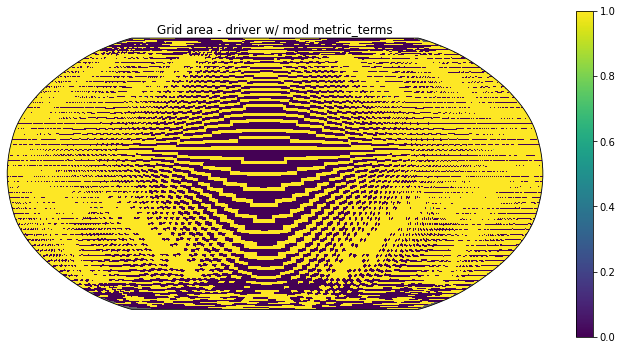

In [39]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from fv3viz import pcolormesh_cube

if rank == 0:
    # fig = plt.figure(figsize=(12, 6))
    # fig.patch.set_facecolor("white")
    # ax = fig.add_subplot(111, projection=ccrs.Robinson())
    # ax.set_facecolor(".4")

    # # plot computational mesh
    # f1 = pcolormesh_cube(
    #     lat_driver_global.data,
    #     lon_driver_global.data,
    #     area_driver_global.data * 2e-11,
    #     cmap="viridis",
    #     vmin=0,
    #     vmax=1,
    # )
    # plt.colorbar(f1, )

    # ax.set_title("Grid area - driver")


    # fig = plt.figure(figsize=(12, 6))
    # fig.patch.set_facecolor("white")
    # ax = fig.add_subplot(111, projection=ccrs.Robinson())
    # ax.set_facecolor(".4")

    # # plot computational mesh
    # f1 = pcolormesh_cube(
    #     lat_fortran_global.data,
    #     lon_fortran_global.data,
    #     area_fortran_global.data * 2e-11,
    #     cmap="viridis",
    #     vmin=0,
    #     vmax=1,
    # )

    # plt.colorbar(f1, )

    # ax.set_title("Grid area - fortran")


    fig = plt.figure(figsize=(12, 6))
    fig.patch.set_facecolor("white")
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    ax.set_facecolor(".4")

    # plot computational mesh
    f1 = pcolormesh_cube(
        lat_driver_mt_global.data,
        lon_driver_mt_global.data,
        area_driver_mt_global.data * 2e-11,
        cmap="viridis",
        vmin=0,
        vmax=1,
    )

    plt.colorbar(f1, )

    ax.set_title("Grid area - driver w/ mod metric_terms")

    plt.show()

In [38]:
    #print(fortran_state.grid_data.lon.min(), fortran_state.grid_data.lon.max())
print(area_driver_mt.data.min(), area_driver_mt.data.max())

[stdout:3] -109688610976516.12 57108932732519.34


[stdout:2] -245876850239203.72 248461436820901.56


[stdout:0] -244100400367783.97 197776365218102.03


[stdout:4] -126681597612415.0 61232772883887.734


[stdout:1] -233717963498404.16 99974084775109.1


[stdout:5] -73838349327425.92 20123873630469.418


In [26]:
dir(fortran_state.grid_data)

Out[2:25]: 
['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_angle_data',
 '_contravariant_data',
 '_horizontal_data',
 '_vertical_data',
 'a11',
 'a12',
 'a21',
 'a22',
 'ak',
 'area',
 'area_64',
 'bk',
 'cos_sg1',
 'cos_sg2',
 'cos_sg3',
 'cos_sg4',
 'cosa',
 'cosa_s',
 'cosa_u',
 'cosa_v',
 'dx',
 'dxa',
 'dxc',
 'dy',
 'dya',
 'dyc',
 'edge_e',
 'edge_n',
 'edge_s',
 'edge_w',
 'ks',
 'lat',
 'lat_agrid',
 'lon',
 'lon_agrid',
 'new_from_metric_terms',
 'p_ref',
 'ptop',
 'rarea',
 'rarea_c',
 'rdx',
 'rdxa',
 'rdxc',
 'rdy',
 'rdya',
 'rdyc',
 'rsin2',
 'rsin_u',
 'rsin_v',
 'rsina',
 'sin_sg1',
 'sin_sg2',
 'sin_sg3',
 'sin_sg4',
 'sina_u',
 'sina_v']

Out[3:25]: 
['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_angle_data',
 '_contravariant_data',
 '_horizontal_data',
 '_vertical_data',
 'a11',
 'a12',
 'a21',
 'a22',
 'ak',
 'area',
 'area_64',
 'bk',
 'cos_sg1',
 'cos_sg2',
 'cos_sg3',
 'cos_sg4',
 'cosa',
 'cosa_s',
 'cosa_u',
 'cosa_v',
 'dx',
 'dxa',
 'dxc',
 'dy',
 'dya',
 'dyc',
 'edge_e',
 'edge_n',
 'edge_s',
 'edge_w',
 'ks',
 'lat',
 'lat_agrid',
 'lon',
 'lon_agrid',
 'new_from_metric_terms',
 'p_ref',
 'ptop',
 'rarea',
 'rarea_c',
 'rdx',
 'rdxa',
 'rdxc',
 'rdy',
 'rdya',
 'rdyc',
 'rsin2',
 'rsin_u',
 'rsin_v',
 'rsina',
 'sin_sg1',
 'sin_sg2',
 'sin_sg3',
 'sin_sg4',
 'sina_u',
 'sina_v']

Out[5:25]: 
['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_angle_data',
 '_contravariant_data',
 '_horizontal_data',
 '_vertical_data',
 'a11',
 'a12',
 'a21',
 'a22',
 'ak',
 'area',
 'area_64',
 'bk',
 'cos_sg1',
 'cos_sg2',
 'cos_sg3',
 'cos_sg4',
 'cosa',
 'cosa_s',
 'cosa_u',
 'cosa_v',
 'dx',
 'dxa',
 'dxc',
 'dy',
 'dya',
 'dyc',
 'edge_e',
 'edge_n',
 'edge_s',
 'edge_w',
 'ks',
 'lat',
 'lat_agrid',
 'lon',
 'lon_agrid',
 'new_from_metric_terms',
 'p_ref',
 'ptop',
 'rarea',
 'rarea_c',
 'rdx',
 'rdxa',
 'rdxc',
 'rdy',
 'rdya',
 'rdyc',
 'rsin2',
 'rsin_u',
 'rsin_v',
 'rsina',
 'sin_sg1',
 'sin_sg2',
 'sin_sg3',
 'sin_sg4',
 'sina_u',
 'sina_v']

Out[0:25]: 
['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_angle_data',
 '_contravariant_data',
 '_horizontal_data',
 '_vertical_data',
 'a11',
 'a12',
 'a21',
 'a22',
 'ak',
 'area',
 'area_64',
 'bk',
 'cos_sg1',
 'cos_sg2',
 'cos_sg3',
 'cos_sg4',
 'cosa',
 'cosa_s',
 'cosa_u',
 'cosa_v',
 'dx',
 'dxa',
 'dxc',
 'dy',
 'dya',
 'dyc',
 'edge_e',
 'edge_n',
 'edge_s',
 'edge_w',
 'ks',
 'lat',
 'lat_agrid',
 'lon',
 'lon_agrid',
 'new_from_metric_terms',
 'p_ref',
 'ptop',
 'rarea',
 'rarea_c',
 'rdx',
 'rdxa',
 'rdxc',
 'rdy',
 'rdya',
 'rdyc',
 'rsin2',
 'rsin_u',
 'rsin_v',
 'rsina',
 'sin_sg1',
 'sin_sg2',
 'sin_sg3',
 'sin_sg4',
 'sina_u',
 'sina_v']

Out[4:25]: 
['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_angle_data',
 '_contravariant_data',
 '_horizontal_data',
 '_vertical_data',
 'a11',
 'a12',
 'a21',
 'a22',
 'ak',
 'area',
 'area_64',
 'bk',
 'cos_sg1',
 'cos_sg2',
 'cos_sg3',
 'cos_sg4',
 'cosa',
 'cosa_s',
 'cosa_u',
 'cosa_v',
 'dx',
 'dxa',
 'dxc',
 'dy',
 'dya',
 'dyc',
 'edge_e',
 'edge_n',
 'edge_s',
 'edge_w',
 'ks',
 'lat',
 'lat_agrid',
 'lon',
 'lon_agrid',
 'new_from_metric_terms',
 'p_ref',
 'ptop',
 'rarea',
 'rarea_c',
 'rdx',
 'rdxa',
 'rdxc',
 'rdy',
 'rdya',
 'rdyc',
 'rsin2',
 'rsin_u',
 'rsin_v',
 'rsina',
 'sin_sg1',
 'sin_sg2',
 'sin_sg3',
 'sin_sg4',
 'sina_u',
 'sina_v']

Out[1:25]: 
['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_angle_data',
 '_contravariant_data',
 '_horizontal_data',
 '_vertical_data',
 'a11',
 'a12',
 'a21',
 'a22',
 'ak',
 'area',
 'area_64',
 'bk',
 'cos_sg1',
 'cos_sg2',
 'cos_sg3',
 'cos_sg4',
 'cosa',
 'cosa_s',
 'cosa_u',
 'cosa_v',
 'dx',
 'dxa',
 'dxc',
 'dy',
 'dya',
 'dyc',
 'edge_e',
 'edge_n',
 'edge_s',
 'edge_w',
 'ks',
 'lat',
 'lat_agrid',
 'lon',
 'lon_agrid',
 'new_from_metric_terms',
 'p_ref',
 'ptop',
 'rarea',
 'rarea_c',
 'rdx',
 'rdxa',
 'rdxc',
 'rdy',
 'rdya',
 'rdyc',
 'rsin2',
 'rsin_u',
 'rsin_v',
 'rsina',
 'sin_sg1',
 'sin_sg2',
 'sin_sg3',
 'sin_sg4',
 'sina_u',
 'sina_v']

In [ ]:
from pace.util import QuantityFactory, SubtileGridSizer

backend = "numpy"

sizer = SubtileGridSizer.from_tile_params(
    nx_tile=12,
    ny_tile=12,
    nz=79,
    n_halo=3,
    extra_dim_lengths={},
    layout=layout,
    tile_partitioner=partitioner.tile,
    tile_rank=communicator.tile.rank,
)

quantity_factory = QuantityFactory.from_backend(sizer=sizer, backend=backend)

In [ ]:
from datetime import datetime

restart_path_1 = "/home/ajdas/pace/restart_data/v1.0"
restart_time_1 = datetime.strptime("2016-08-11 00:00:00", "%Y-%m-%d %H:%M:%S")
fortran_data_1 = True
restart_path_4 = "/home/ajdas/pace/restart_data/v4.0"
restart_time_4 = datetime.strptime("2016-08-01 00:15:00", "%Y-%m-%d %H:%M:%S")
fortran_data_4 = True


In [ ]:
%%capture
from pace.driver.initialization import RestartConfig

restart_config_1 = RestartConfig(path=restart_path_1, start_time=restart_time_1, fortran_data=fortran_data_1)
fortran_state_1 = restart_config.get_driver_state(quantity_factory, communicator)
restart_config_4 = RestartConfig(path=restart_path_4, start_time=restart_time_4, fortran_data=fortran_data_4)
fortran_state_4 = restart_config.get_driver_state(quantity_factory, communicator)

In [ ]:
datadir_1 = "/home/ajdas/pace/restart_data/v1.0/"
datadir_4 = "/home/ajdas/pace/restart_data/v4.0/"

In [ ]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ak_driver_1 = fortran_state_1.grid_data.ak.data
bk_driver_1 = fortran_state_1.grid_data.bk.data
ak_driver_4 = fortran_state_1.grid_data.ak.data
bk_driver_4 = fortran_state_1.grid_data.bk.data

In [ ]:
data = Dataset(datadir_1 + "fv_core.res.nc", "r")
ak_fort_1 = np.array(data["ak"][0])
bk_fort_1 = np.array(data["bk"][0])
data.close()
data = Dataset(datadir_4 + "fv_core.res.nc", "r")
ak_fort_4 = np.array(data["ak"][0])
bk_fort_4 = np.array(data["bk"][0])
data.close()

In [ ]:
fIn_ser_1 = "/home/ajdas/pace/test_data/8.1.1/v1.0/Driver-In.nc"
fIn_ser_4 = "/home/ajdas/pace/test_data/8.1.1/v4.0/Driver-In.nc"
data = Dataset(fIn_ser_1, "r")
ak_ser_1 = np.array(data["ak"][0, 0])
bk_ser_1 = np.array(data["bk"][0, 0])
data.close()
data = Dataset(fIn_ser_4, "r")
ak_ser_4 = np.array(data["ak"][0, 0])
bk_ser_4 = np.array(data["bk"][0, 0])
data.close()

In [ ]:
if rank == 0:
    fig = plt.figure(figsize = (8, 4))
    ax_ak = fig.add_subplot(121)
    ax_bk = fig.add_subplot(122)

    ax_ak.plot(ak_driver_1, np.arange(80), c='k', lw=2, label="driver")
    ax_ak.plot(ak_fort_1, np.arange(80), c='r', lw=2, label="fortran")
    ax_ak.plot(ak_ser_1, np.arange(80), c='b', lw=2, label="serialized")
    ax_bk.plot(bk_driver_1, np.arange(80), c='k', lw=2)
    ax_bk.plot(bk_fort_1, np.arange(80), c='r', lw=2)
    ax_bk.plot(bk_ser_1, np.arange(80), c='b', lw=2)

    ax_ak.set_title("ak - baroclinic 10 day")
    ax_bk.set_title("bk - baroclinic 10 day")

    ax_ak.legend(loc=1)


    fig = plt.figure(figsize = (8, 4))
    ax_ak = fig.add_subplot(121)
    ax_bk = fig.add_subplot(122)

    ax_ak.plot(ak_driver_4, np.arange(80), c='k', lw=2, label="driver")
    ax_ak.plot(ak_fort_4, np.arange(80), c='r', lw=2, label="fortran")
    ax_ak.plot(ak_ser_4, np.arange(80), c='b', lw=2, label="serialized")
    ax_bk.plot(bk_driver_4, np.arange(80), c='k', lw=2)
    ax_bk.plot(bk_fort_4, np.arange(80), c='r', lw=2)
    ax_bk.plot(bk_ser_4, np.arange(80), c='b', lw=2)

    ax_ak.set_title("ak - standard 15 min")
    ax_bk.set_title("bk - standard 15 min")

    ax_ak.legend(loc=1)

    plt.show()

In [ ]:
# lon_tmp = fortran_state.grid_data.lon
# lat_tmp = fortran_state.grid_data.lat

In [ ]:
# import numpy as np
# from pace.util import Quantity

# lon_driver_mt = Quantity(
#     data = fortran_state.grid_data.lon.data * 180/np.pi,
#     dims = ("x_interface", "y_interface"),
#     units = "degree",
#     origin = (3, 3),
#     extent = (129, 129),
#     gt4py_backend=backend,
# )

# lat_driver_mt = Quantity(
#     data = fortran_state.grid_data.lat.data * 180/np.pi,
#     dims = ("x_interface", "y_interface"),
#     units = "degree",
#     origin = (3, 3),
#     extent = (129, 129),
#     gt4py_backend=backend,
# )

# lona_driver_mt = Quantity(
#     data = fortran_state.grid_data.lon_agrid.data * 180/np.pi,
#     dims = ("x", "y"),
#     units = "degree",
#     origin = (3, 3),
#     extent = (128, 128),
#     gt4py_backend=backend,
# )

# lata_driver_mt = Quantity(
#     data = fortran_state.grid_data.lat_agrid.data * 180/np.pi,
#     dims = ("x", "y"),
#     units = "degree",
#     origin = (3, 3),
#     extent = (128, 128),
#     gt4py_backend=backend,
# )

# area_driver_mt = Quantity(
#     data = fortran_state.grid_data.area.data,
#     dims = ("x", "y"),
#     units = "degree",
#     origin = (3, 3),
#     extent = (128, 128),
#     gt4py_backend=backend,
# )

# lon_driver_mt_global = communicator.gather(lon_driver_mt)
# lat_driver_mt_global = communicator.gather(lat_driver_mt)
# lona_driver_mt_global = communicator.gather(lona_driver_mt)
# lata_driver_mt_global = communicator.gather(lata_driver_mt)
# area_driver_mt_global = communicator.gather(area_driver_mt)

In [ ]:
# import matplotlib.pyplot as plt
# from cartopy import crs as ccrs
# from fv3viz import pcolormesh_cube

# if rank == 0:
#     fig = plt.figure(figsize=(12, 6))
#     fig.patch.set_facecolor("white")
#     ax = fig.add_subplot(111, projection=ccrs.Robinson())
#     ax.set_facecolor(".4")

#     # plot computational mesh
#     f1 = pcolormesh_cube(
#         lat_driver_global.data,
#         lon_driver_global.data,
#         area_driver_global.data * 2e-11,
#         cmap="viridis",
#         vmin=0,
#         vmax=1,
#     )
#     plt.colorbar(f1, )

#     ax.set_title("Grid area - driver")


#     fig = plt.figure(figsize=(12, 6))
#     fig.patch.set_facecolor("white")
#     ax = fig.add_subplot(111, projection=ccrs.Robinson())
#     ax.set_facecolor(".4")

#     # plot computational mesh
#     f1 = pcolormesh_cube(
#         lat_fortran_global.data,
#         lon_fortran_global.data,
#         area_fortran_global.data * 2e-11,
#         cmap="viridis",
#         vmin=0,
#         vmax=1,
#     )

#     plt.colorbar(f1, )

#     ax.set_title("Grid area - fortran")


#     fig = plt.figure(figsize=(12, 6))
#     fig.patch.set_facecolor("white")
#     ax = fig.add_subplot(111, projection=ccrs.Robinson())
#     ax.set_facecolor(".4")

#     # plot computational mesh
#     f1 = pcolormesh_cube(
#         lat_mt_global.data,
#         lon_mt_global.data,
#         area_mt_global.data * 2e-11,
#         cmap="viridis",
#         vmin=0,
#         vmax=1,
#     )

#     plt.colorbar(f1, )

#     ax.set_title("Grid area - metric_terms")

#     fig = plt.figure(figsize=(12, 6))
#     fig.patch.set_facecolor("white")
#     ax = fig.add_subplot(111, projection=ccrs.Robinson())
#     ax.set_facecolor(".4")

#     # plot computational mesh
#     f1 = pcolormesh_cube(
#         lat_driver_mt_global.data,
#         lon_driver_mt_global.data,
#         area_driver_mt_global.data * 2e-11,
#         cmap="viridis",
#         vmin=0,
#         vmax=1,
#     )

#     plt.colorbar(f1, )

#     ax.set_title("Grid area - driver w/ mod metric_terms")

#     plt.show()